# OpenBB Tools

## Getting Started

### Install dependencies

In [ ]:
!pip install openbb
!pip install openbb-charting

!pip install pydantic==2.5

!pip install langchain
!pip install langchain_community
!pip install langchain_openai
# need to restart runtime after installing pydantic

### Set the OpenAI API Key

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "your-api-key

### Import packages

In [1]:
from openbb import obb

### Login

In [ ]:
obb.account.login(pat="PAT")

## OpenBB tool pre-requisites

### Callable

In [2]:
obb.equity.price.historical(symbol="AAPL", provider="polygon").to_df()

open      high       low   close       volume      vwap  \
date                                                                     
2023-02-07  150.640  155.2300  150.6400  154.65   83322551.0  153.4202   
2023-02-08  153.880  154.5800  151.1680  151.92   63620079.0  152.3636   
2023-02-09  153.775  154.3300  150.4200  150.87   55994243.0  152.2769   
2023-02-10  149.460  151.3401  149.2200  151.01   57388108.0  150.4054   
2023-02-13  150.952  154.2600  150.9200  153.85   62199013.0  153.2310   
...             ...       ...       ...     ...          ...       ...   
2024-02-01  183.985  186.9500  183.8200  186.86   64885408.0  185.5688   
2024-02-02  179.860  187.3300  179.2500  185.85  102527680.0  184.7440   
2024-02-05  188.150  189.2500  185.8400  187.68   69654320.0  187.6824   
2024-02-06  186.860  189.3100  186.7695  189.30   43490528.0  188.4788   
2024-02-07  190.630  191.0500  188.6100  189.00   31515523.0  189.4285   

            transactions  
date                      
2023-02-07        661767  
2023-02-08        524140  
2023-02-09        471973  
2023-02-10        443405  
2023-02-13        506668  
...                  ...  
2024-02-01        820977  
2024-02-02       1108465  
2024-02-05        804748  
2024-02-06        530823  
2024-02-07        474967  

[252 rows x 7 columns]

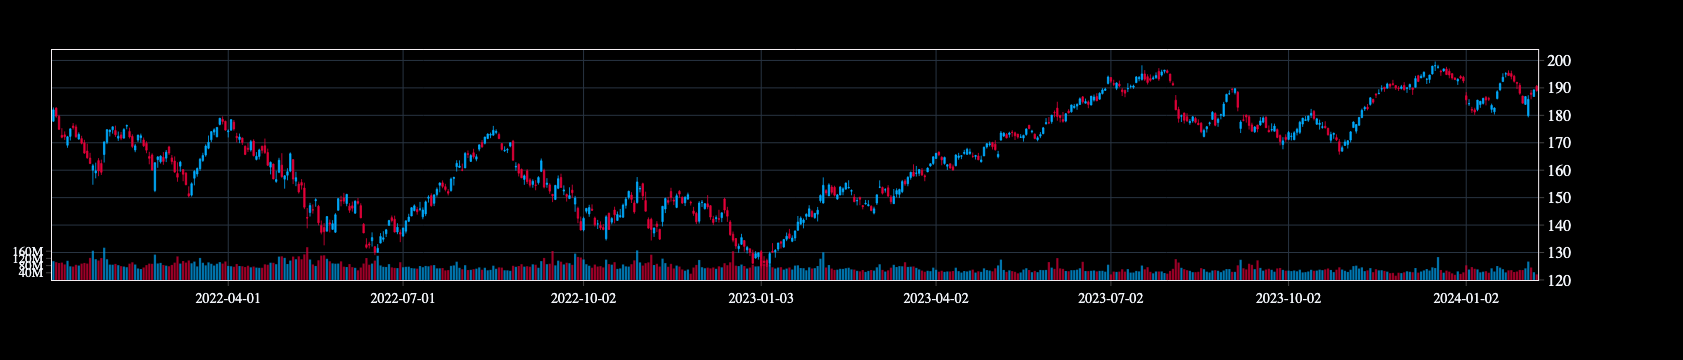

In [3]:
obb.equity.price.historical(
    "AAPL", start_date="2022-01-01", provider="polygon"
).charting.to_chart()

### Input Schema

In [4]:
obb.coverage.command_model[".equity.price.historical"]["openbb"]["QueryParams"]

{'fields': {'symbol': FieldInfo(annotation=str, required=True, description='Symbol to get data for.'),
  'interval': FieldInfo(annotation=Union[str, NoneType], required=False, default='1d', description='Time interval of the data to return.'),
  'start_date': FieldInfo(annotation=Union[date, NoneType], required=False, description='Start date of the data, in YYYY-MM-DD format.'),
  'end_date': FieldInfo(annotation=Union[date, NoneType], required=False, description='End date of the data, in YYYY-MM-DD format.')},
 'docstring': 'Equity Historical Price Query.'}

In [5]:
obb.coverage.command_model[".equity.price.historical"]["polygon"]["QueryParams"]

{'fields': {'sort': FieldInfo(annotation=Literal['asc', 'desc'], required=False, default='desc', description='Sort order of the data.'),
  'limit': FieldInfo(annotation=int, required=False, default=49999, description='The number of data entries to return.', metadata=[Gt(gt=0)]),
  'adjusted': FieldInfo(annotation=bool, required=False, default=True, description='Output time series is adjusted by historical split and dividend events.')},
 'docstring': 'Polygon Equity Historical Price Query.\n\n    Source: https://polygon.io/docs/stocks/getting-started\n    ',
 'alias_dict': {}}

### Documentation

In [6]:
help(obb.equity.price.historical)

Help on method historical in module openbb.package.equity_price:

historical(symbol: Annotated[Union[str, List[str]], OpenBBCustomParameter(description='Symbol to get data for.')], interval: Annotated[Optional[str], OpenBBCustomParameter(description='Time interval of the data to return.')] = '1d', start_date: Annotated[Union[datetime.date, NoneType, str], OpenBBCustomParameter(description='Start date of the data, in YYYY-MM-DD format.')] = None, end_date: Annotated[Union[datetime.date, NoneType, str], OpenBBCustomParameter(description='End date of the data, in YYYY-MM-DD format.')] = None, chart: bool = False, provider: Optional[Literal['fmp', 'intrinio', 'polygon', 'tiingo', 'yfinance']] = None, **kwargs) -> openbb_core.app.model.obbject.OBBject method of openbb.package.equity_price.ROUTER_equity_price instance
    Equity Historical price. Load stock data for a specific ticker.
    
    Parameters
    ----------
    symbol : str
        Symbol to get data for.
    interval : Optional[

## OpenBB tool

In [7]:
from langchain_core.tools import StructuredTool

llm_historical_price = StructuredTool.from_function(
    func=obb.equity.price.historical,
    description=obb.equity.price.historical.__doc__.split("\n")[
        0
    ],  # Use first line of docstring
)

## Multiple OpenBB Tools

In [8]:
llm_tools = [
    StructuredTool.from_function(
        name=name,
        func=schema["callable"],
        description=schema["callable"].__doc__.split("\n")[0],
    )
    for name, schema in obb.coverage.command_schemas().items()
]

## OpenBB Tools fed to agent

In [9]:
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a very powerful assistant, but don't know current events"),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

llm_tools = [
    StructuredTool.from_function(
        func=obb.equity.price.quote,
        description=obb.equity.price.quote.__doc__.split("\n")[0],
    )
]

llm = ChatOpenAI(model="gpt-4", temperature=0.1)

agent = create_openai_functions_agent(llm=llm, tools=llm_tools, prompt=prompt)
agent_executor = AgentExecutor(agent=agent, tools=llm_tools, verbose=True)

agent_executor.invoke({"input": "What is the latest stock price of AAPL?"})



> Entering new AgentExecutor chain...

Invoking: `quote` with `{'symbol': 'AAPL'}`


id='065c3d7f-db6f-7f8e-8000-07203cdade8d' results=[FMPEquityQuoteData(symbol=AAPL, asset_type=None, name=Apple Inc., exchange=NASDAQ, bid=None, bid_size=None, bid_exchange=None, ask=None, ask_size=None, ask_exchange=None, quote_conditions=None, quote_indicators=None, sales_conditions=None, sequence_number=None, market_center=None, participant_timestamp=None, trf_timestamp=None, sip_timestamp=None, last_price=189.0155, last_tick=None, last_size=None, last_timestamp=2024-02-07 19:20:26+00:00, open=190.64, high=191.03, low=188.61, close=None, volume=31533293, exchange_volume=None, prev_close=189.3, change=-0.2845, change_percent=-0.001503, year_high=199.62, year_low=143.9, price_avg50=190.551, price_avg200=182.7054, avg_volume=53796024, market_cap=2922538759450.0, shares_outstanding=15461900000, eps=6.43, pe=29.4, earnings_announcement=2024-05-02 10:59:00+00:00)] provider='fmp' warnings=None chart=None 

{'input': 'What is the latest stock price of AAPL?',
 'output': 'The latest stock price of Apple Inc. (AAPL) is $189.0155.'}